## Setup the environment

In [16]:
!pip install beautifulsoup4
!pip install requests
!pip install ipywidgets
!pip install dash plotly

In [17]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
import ipywidgets as widgets
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from google.colab import drive
import scipy.stats as stats


## Scraping part

In [18]:
#load page content
# url = "https://www.skinnytaste.com/recipes/"
url = 'https://www.skinnytaste.com/recipe-index/'

In [19]:
# dictionary to store key points
info = {"title": [],
        'cal': [],
        'PP': [],
        'key': [],
        'summary': []}

In [20]:
# dictionary to store links for recipe and image
first_page = {'links': [],
              'img': []}


for i in range(2, 52):
  # loading html page
  r = requests.get(url)
  soup = bs(r.text, 'html.parser')
  # class_content = soup.select('.post-content')
  recipe_list = soup.select('.post-content')

  # Find all div elements to get the url for each of the recipe
  divs = soup.find_all('div', class_='post-thumb-img-content post-thumb')

  # Loop through each div and extract the 'a' tag links
  for div in divs:
      link_tag = div.find('a')
      if link_tag:
          link = link_tag['href']
          first_page['links'].append(link)

      # storing th link of the image as well
      img_tag = div.find('img')
      img_src = None
      if img_tag:
        if 'data-lazy-src' in img_tag.attrs:
            img_src = img_tag['data-lazy-src']
        elif 'data-lazy-srcset' in img_tag.attrs:
            img_src = img_tag['data-lazy-srcset']
        elif 'src' in img_tag.attrs:
            img_src = img_tag['src']
      first_page['img'].append(img_src)


  # update url for each page
  url = 'https://www.skinnytaste.com/recipe-index/'
  # url = url + 'page/'+str(i)+'/'
  url = url + '?_paged='+str(i)

  # sleeping to make sure that pages loaded
  # time.sleep(2)




In [21]:
# to check if any page has not be scrapped
non_scraped = 0

# going through each URLs
for url in first_page['links']:
  r = requests.get(url)
  # time.sleep(2)

  # loading html page
  soup = bs(r.text, 'html.parser')

  try:
        # new_url = bs(requests.get(soup).text, 'html.parser')
        title = soup.find('h1').string
  except:
    print("No title found")

  # appending title
  info['title'].append(title)


  # extracting the calories
  try:
    cal = float(soup.find('div', class_='post-recipe-info-left ast-flex').find_all('span')[1].get_text(strip=True).replace('Cals:', '').strip())
    info['cal'].append(cal)
  except:
    info['cal'].append(None)
    # print(f"no cal found at: {url}")


  # extractning PP
  try:
    pp = float(soup.find('div', class_='post-recipe-info-left ast-flex').find_all('span')[0].get_text(strip=True))
    info['PP'].append(pp)
  except:
    info['PP'].append(None)
    # print(f"no PP found at: {url}")

  try:

    # extracting the reciepe keys
    li_tags = soup.find('ul', class_='cat-icons post-icons').find_all('li')
    # Extract the keys
    keys = []
    for li in li_tags:
        # Find the 'a' tag within each 'li'
        a_tag = li.find('a')
        if a_tag:
            class_attr = a_tag.get('class', [])
            for class_name in class_attr:
                if 'cat-icon__' in class_name:
                    # Get the part after 'cat-icon__'
                    key = class_name.split('cat-icon__')[-1].upper()
                    keys.append(key)

    # adding
    info['key'].append(keys)
  except:
    info['key'].append(None)
    # print(f"no Key found at: {url}")

  #entry-content clear
  try:

    summary = soup.find('div', class_='entry-content clear').find_all('p')[0].get_text(strip=True)
    info['summary'].append(summary)
  except:
    info['summary'].append(None)






In [22]:
## Adding the image links the dictionary as well
info['img'] = first_page['img']

In [23]:
# converting the dictionary to dataframe
data = pd.DataFrame(info)
data.head()

,title,cal,PP,key,summary,img
0,Free 7 Day Healthy Meal Plan (Sept 30-Oct 6),NaN,NaN,None,"A free 7-day, flexible weight loss meal plan i...",https://www.skinnytaste.com/wp-content/uploads...
1,Breakfast Burritos,261.0,5.0,"[AF, FM, HF, KF, MP, Q]",These freezerbreakfastburritos are stuffed wit...,https://www.skinnytaste.com/wp-content/uploads...
2,Crustless Pumpkin Pie,124.5,2.0,"[DF, GF, HF, V]","Skip the crust and make this easy gluten-free,...",https://www.skinnytaste.com/wp-content/uploads...
3,Red Curry Salmon,349.0,6.0,"[DF, GF, HP]",Thai-inspired Red Curry Salmon is simmered in ...,https://www.skinnytaste.com/wp-content/uploads...
4,Apple Butter,34.0,1.0,"[DF, GF, KF, V]",This easy apple butter recipe simmers on the s...,https://www.skinnytaste.com/wp-content/uploads...


In [24]:
# total recipes
len(data)

1000

## EDA and Data Visualization

In [25]:
## Preprocessing the dataset

In [26]:
# The null values are indicating the exracted page/blog is not a recipe. It is just a normal article
data.isnull().sum()

,0
title,0
cal,58
PP,62
key,52
summary,0
img,0


In [27]:
# removing the normal articles
data.dropna(inplace=True)
len(data)

928

### Storing the dataset

In [28]:
## storing the data as csv file to use later
# data.to_csv("data_mini.csv", index=False)

In [29]:
## saving the data to drive:
# drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
## Define the path where you want to save the CSV file
# file_path = '/content/drive/My Drive/dataframe.csv'

## Save the DataFrame as a CSV file
# data.to_csv(file_path, index=False)

In [35]:
# Loading the dataset frome drive
# Download the CSV file
file_url = 'https://drive.google.com/uc?export=download&id=1hUefmJ4kRKiVj7q2ifHOTlUWcCqiPaUD'
# file_url = 'https://drive.google.com/file/d/1hUefmJ4kRKiVj7q2ifHOTlUWcCqiPaUD/view?usp=sharing'
response = requests.get(file_url)

# Save the content to a CSV file
with open('data.csv', 'wb') as f:
    f.write(response.content)

# Load the CSV into a DataFrame
data = pd.read_csv('data.csv')

data.head()

,title,cal,PP,key,summary,img
0,Breakfast Burritos,261.0,5.0,"['AF', 'FM', 'HF', 'KF', 'MP', 'Q']",These freezerbreakfastburritos are stuffed wit...,https://www.skinnytaste.com/wp-content/uploads...
1,Crustless Pumpkin Pie,124.5,2.0,"['DF', 'GF', 'HF', 'V']","Skip the crust and make this easy gluten-free,...",https://www.skinnytaste.com/wp-content/uploads...
2,Red Curry Salmon,349.0,6.0,"['DF', 'GF', 'HP']",Thai-inspired Red Curry Salmon is simmered in ...,https://www.skinnytaste.com/wp-content/uploads...
3,Apple Butter,34.0,1.0,"['DF', 'GF', 'KF', 'V']",This easy apple butter recipe simmers on the s...,https://www.skinnytaste.com/wp-content/uploads...
4,Roasted Delicata Squash,177.0,4.0,"['DF', 'GF', 'V']","Roasted Delicata Squash with toasted almonds, ...",https://www.skinnytaste.com/wp-content/uploads...


### cleaning dataset

In [36]:
# listing all the possible keys from the website
all_keys = ['AF', 'DF', 'FM', 'GF', 'HP', 'HF', 'KF', 'LC', 'MP', 'PC', 'SC', 'Q', 'V', 'W']

# Create new columns for each key
for key in all_keys:
    data[key] = data['key'].apply(lambda x: 1 if x is not None and key in x else 0)

# Drop the existing key column
data.drop('key', axis=1, inplace=True)

In [37]:
data.head()

,title,cal,PP,summary,img,AF,DF,FM,GF,HP,HF,KF,LC,MP,PC,SC,Q,V,W
0,Breakfast Burritos,261.0,5.0,These freezerbreakfastburritos are stuffed wit...,https://www.skinnytaste.com/wp-content/uploads...,1,0,1,0,0,1,1,0,1,0,0,1,0,0
1,Crustless Pumpkin Pie,124.5,2.0,"Skip the crust and make this easy gluten-free,...",https://www.skinnytaste.com/wp-content/uploads...,0,1,0,1,0,1,0,0,0,0,0,0,1,0
2,Red Curry Salmon,349.0,6.0,Thai-inspired Red Curry Salmon is simmered in ...,https://www.skinnytaste.com/wp-content/uploads...,0,1,0,1,1,0,0,0,0,0,0,0,0,0
3,Apple Butter,34.0,1.0,This easy apple butter recipe simmers on the s...,https://www.skinnytaste.com/wp-content/uploads...,0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,Roasted Delicata Squash,177.0,4.0,"Roasted Delicata Squash with toasted almonds, ...",https://www.skinnytaste.com/wp-content/uploads...,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [38]:
len(data)

928

In [39]:
# to ensure no duplicate scrapping
data.drop_duplicates(inplace=True)
len(data)

928

### Calories distribution

Text(0.5, 1.0, 'Violin plot')

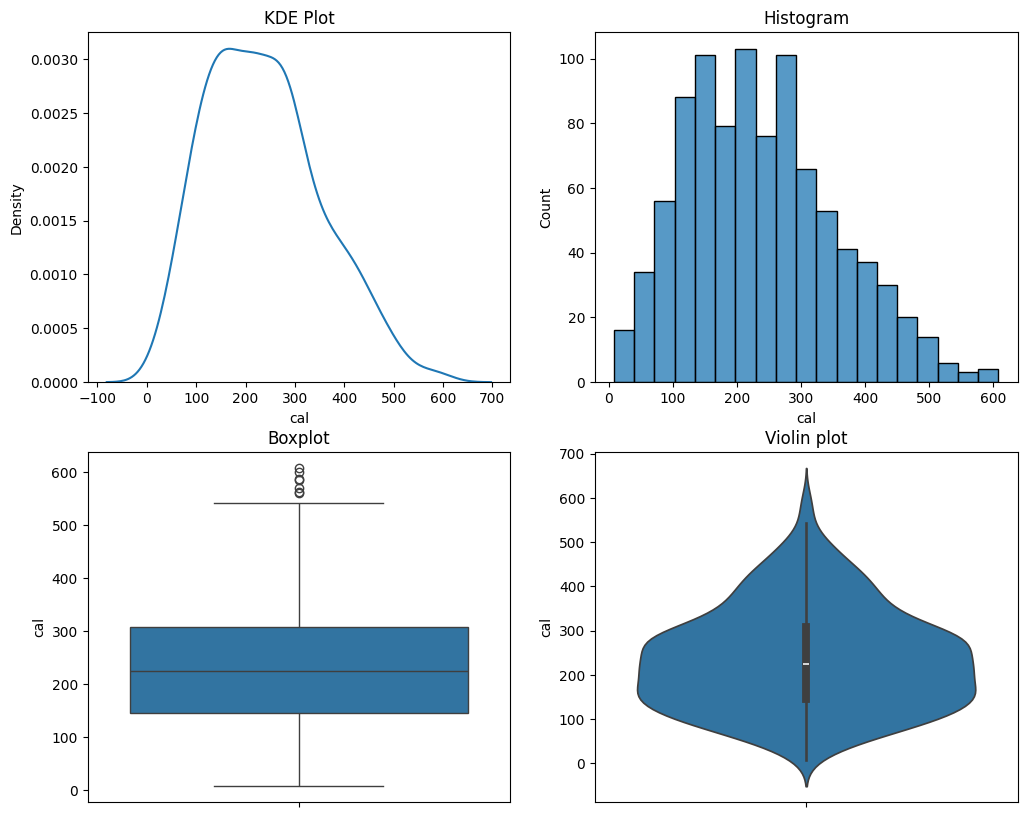

In [40]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# KDE Plot
sns.kdeplot(data, x='cal', ax=axs[0, 0])
axs[0, 0].set_title('KDE Plot')

# Histogram
sns.histplot(data, x='cal', ax=axs[0, 1])
axs[0, 1].set_title('Histogram')

# Boxplot
sns.boxplot(data['cal'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot')

# violinplot
sns.violinplot(data['cal'], ax=axs[1, 1])
axs[1, 1].set_title('Violin plot')

In [41]:
data['cal'].describe()

,cal
count,928.000000
mean,237.247629
std,116.683742
min,8.000000
25%,146.375000
50%,225.500000
75%,308.250000
max,608.000000


### recipe key distribution

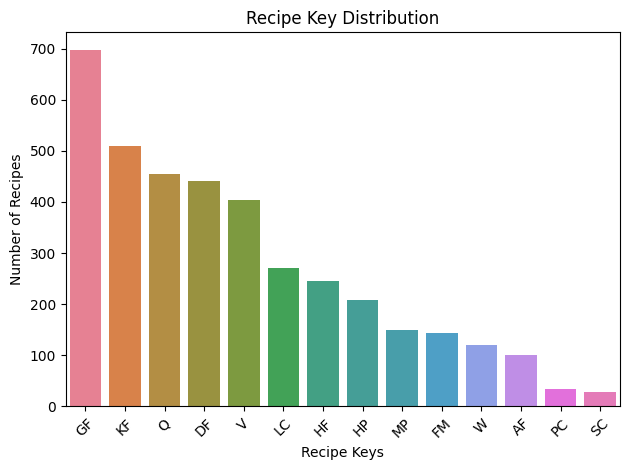

In [42]:
all_keys = ['AF', 'DF', 'FM', 'GF', 'HP', 'HF', 'KF', 'LC', 'MP', 'PC', 'SC', 'Q', 'V', 'W']

key_counts = data[all_keys].sum()
key_counts = key_counts.sort_values(ascending=False)
sns.barplot(x=key_counts.index, y=key_counts.values, hue=key_counts.index)

plt.title('Recipe Key Distribution')
plt.ylabel('Number of Recipes')
plt.xlabel('Recipe Keys')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

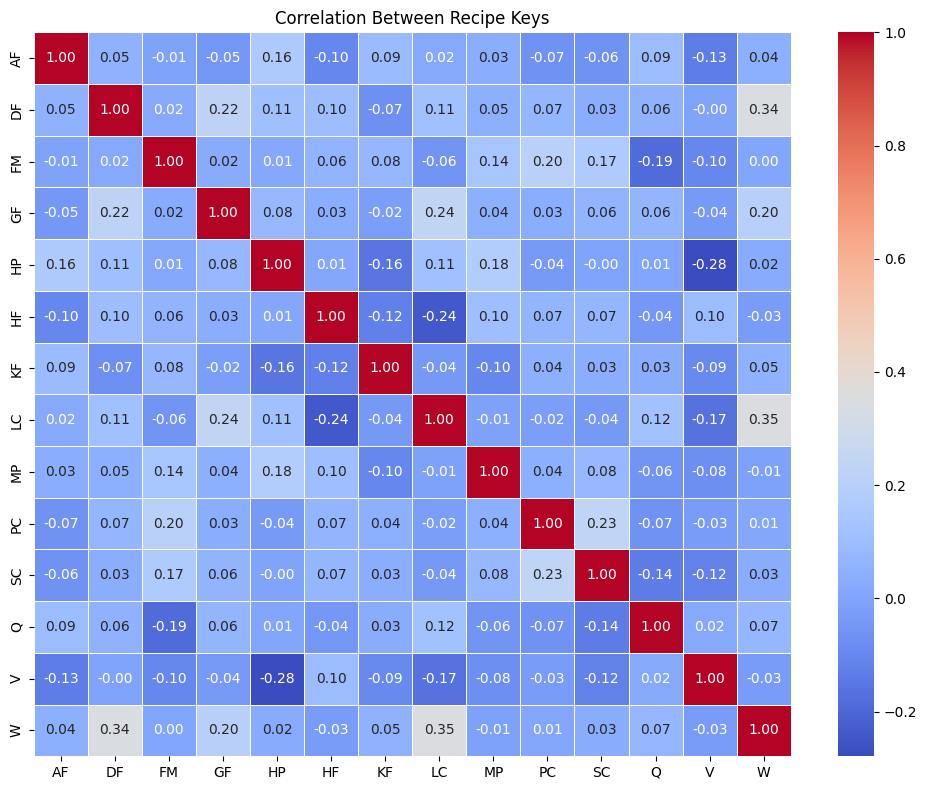

In [43]:
plt.figure(figsize=(10, 8))
key_corr = data[all_keys].corr()
sns.heatmap(key_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Between Recipe Keys')
plt.tight_layout()
plt.show()


### points distribution

Text(0.5, 1.0, 'ViolinPlot')

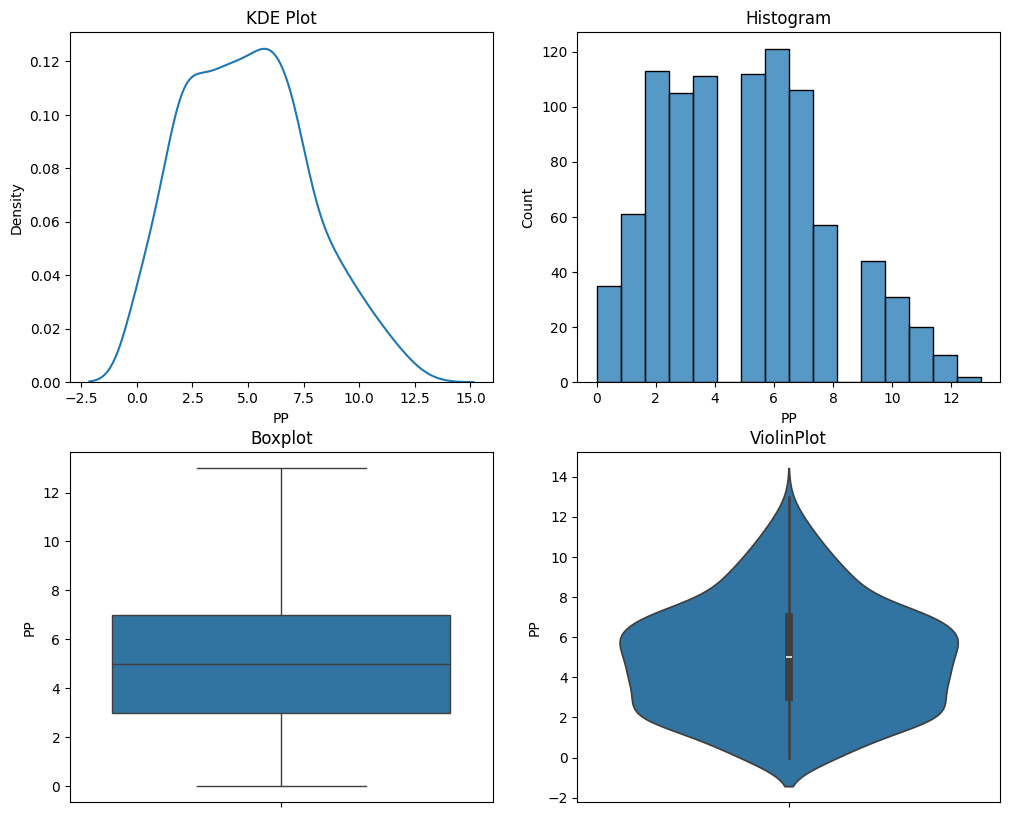

In [44]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# KDE Plot
sns.kdeplot(data, x='PP', ax=axs[0, 0])
axs[0, 0].set_title('KDE Plot')

# Histogram
sns.histplot(data, x='PP', ax=axs[0, 1])
axs[0, 1].set_title('Histogram')

# Boxplot
sns.boxplot(data['PP'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot')

# violinplot
sns.violinplot(data['PP'], ax=axs[1, 1])
axs[1, 1].set_title('ViolinPlot')

<Axes: xlabel='PP', ylabel='count'>

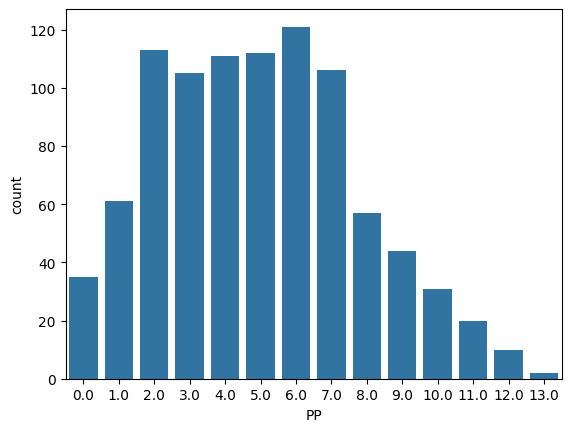

In [45]:
sns.countplot(data, x='PP')

Text(0.5, 1.0, 'ECDF Plot')

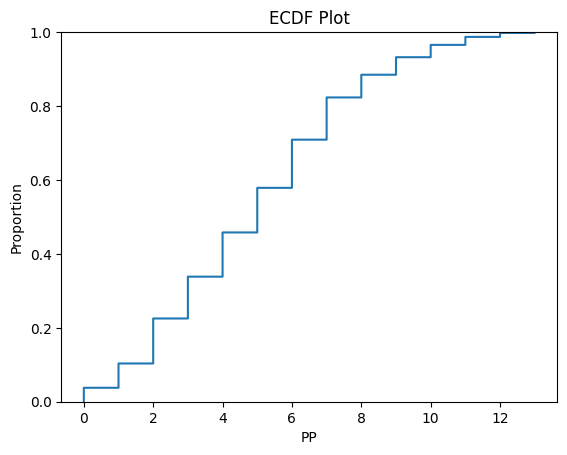

In [46]:
sns.ecdfplot(data['PP'])
plt.title('ECDF Plot')

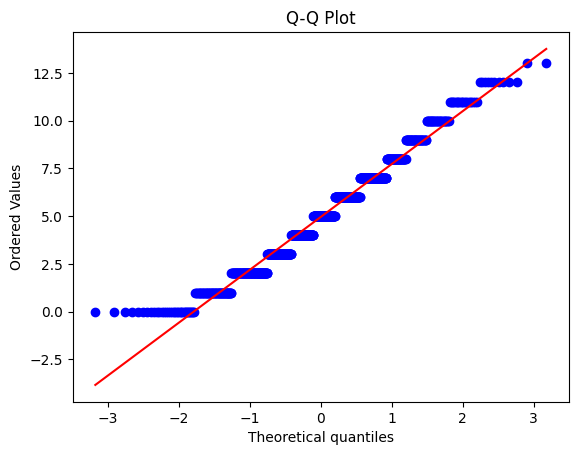

In [47]:

# Generate Q-Q plot
stats.probplot(data['PP'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


Text(0.5, 1.0, 'Violin plot')

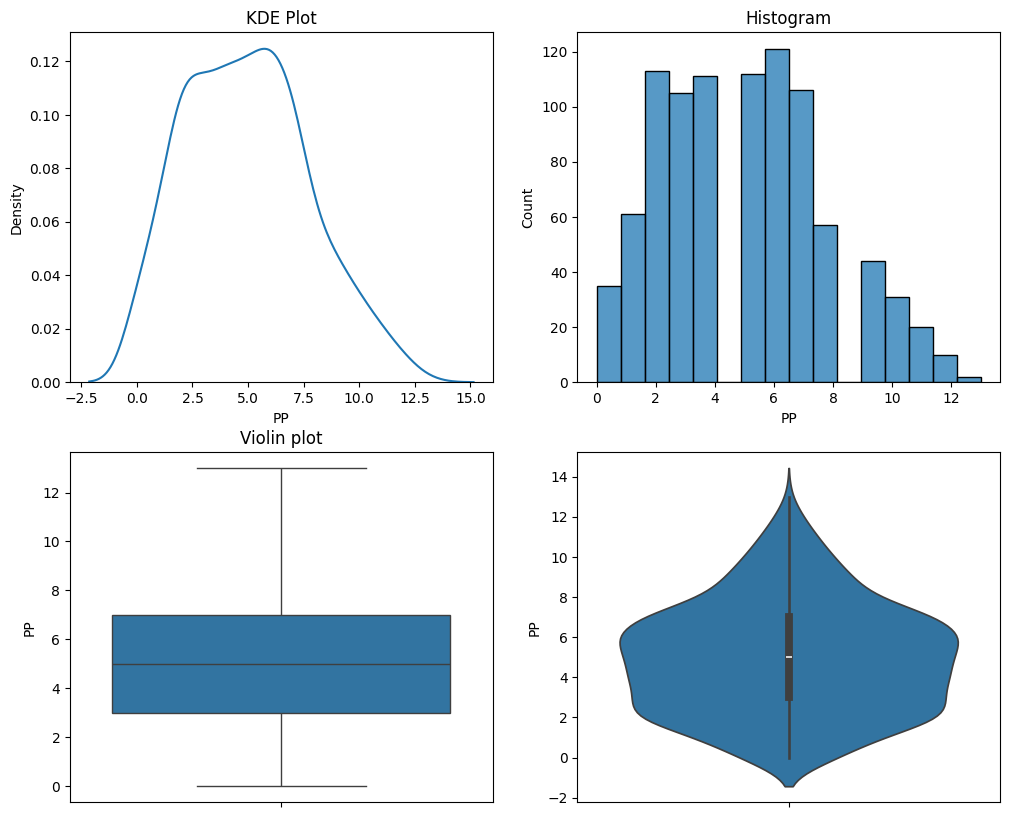

In [49]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# KDE Plot
sns.kdeplot(data, x='PP', ax=axs[0, 0])
axs[0, 0].set_title('KDE Plot')

# Histogram
sns.histplot(data, x='PP', ax=axs[0, 1])
axs[0, 1].set_title('Histogram')

# Boxplot
sns.boxplot(data['PP'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot')

# violinplot
sns.violinplot(data['PP'], ax=axs[1, 1])
axs[1, 0].set_title('Violin plot')

In [50]:
#### comparision

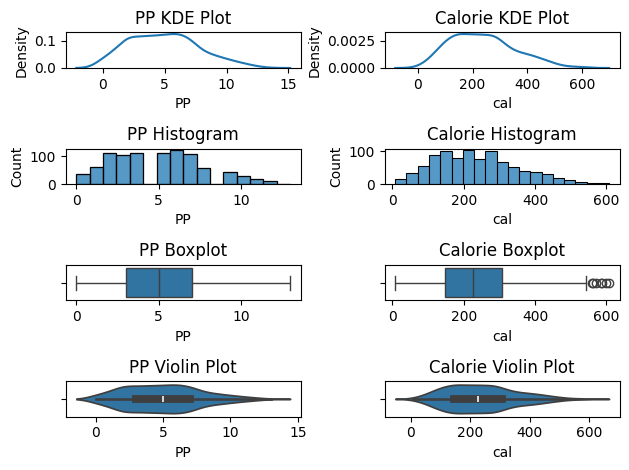

In [53]:
# Create the figure and subplots
fig, axs = plt.subplots(4, 2)

# KDE Plot for PP
sns.kdeplot(data, x='PP', ax=axs[0, 0])
axs[0, 0].set_title('PP KDE Plot')

# KDE Plot for cal
sns.kdeplot(data, x='cal', ax=axs[0, 1])
axs[0, 1].set_title('Calorie KDE Plot')

# Histogram for PP
sns.histplot(data, x='PP', ax=axs[1, 0])
axs[1, 0].set_title('PP Histogram')

# Histogram for cal
sns.histplot(data, x='cal', ax=axs[1, 1])
axs[1, 1].set_title('Calorie Histogram')

# Boxplot for PP
sns.boxplot(x=data['PP'], ax=axs[2, 0])
axs[2, 0].set_title('PP Boxplot')

# Boxplot for cal
sns.boxplot(x=data['cal'], ax=axs[2, 1])
axs[2, 1].set_title('Calorie Boxplot')

# Violin plot for PP
sns.violinplot(x=data['PP'], ax=axs[3, 0])
axs[3, 0].set_title('PP Violin Plot')

# Violin plot for cal
sns.violinplot(x=data['cal'], ax=axs[3, 1])
axs[3, 1].set_title('Calorie Violin Plot')

plt.tight_layout()
plt.show()


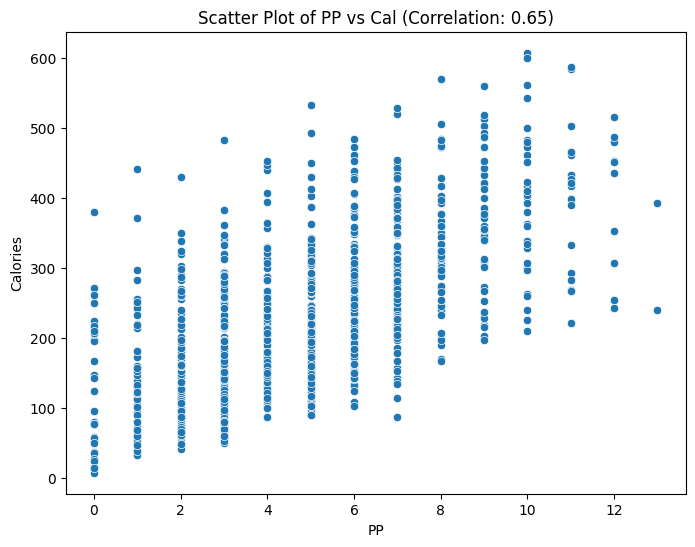

In [54]:


# Calculate correlation
correlation = data['PP'].corr(data['cal'])

# Scatter plot to show correlation visually
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='PP', y='cal')
plt.title(f'Scatter Plot of PP vs Cal (Correlation: {correlation:.2f})')
plt.xlabel('PP')
plt.ylabel('Calories')

plt.show()


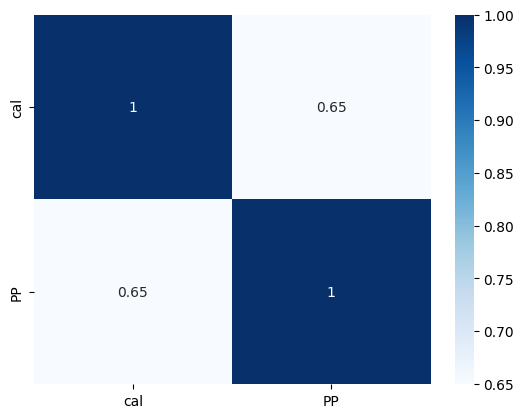

In [55]:
cor = data[['cal', 'PP']].corr()

sns.heatmap(cor, annot=True, cmap='Blues')
plt.show()

## User interface

In [56]:

'''
###################################################################################################################
I had used ChatGPT for styling Purpose for this interface (The layout part). So, the styling credit goes to ChatGPT
##################################################################################################################
'''

df = data
# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.P("Select Calories Range:"),
    dcc.RangeSlider(
        id='calorie-slider',
        min=df['cal'].min(),
        max=df['cal'].max(),
        value=[df['cal'].min(), df['cal'].max()],
        marks={i: str(i) for i in range(int(df['cal'].min()), int(df['cal'].max()) + 1, 50)},
        step=1,
        pushable=True,
        tooltip={"placement": "bottom", "always_visible": True}
    ),
     html.P("Select PP Range:"),
    dcc.RangeSlider(
        id='point-slider',
        min=df['PP'].min(),
        max=df['PP'].max(),
        value=[df['PP'].min(), df['PP'].max()],
        marks={i: str(i) for i in range(int(df['PP'].min()), int(df['PP'].max()) + 1)},
        step=1,
        pushable=True,
        tooltip={"placement": "bottom", "always_visible": True}
    ),
    html.Div(id='output-container')
])


@app.callback(
    Output('output-container', 'children'),
    Input('calorie-slider', 'value'),
    Input('point-slider', 'value')
)
def update_output(calorie_range, point_range):
    # Filter DataFrame based on user input
    filtered_df = df[
        (df['cal'] >= calorie_range[0]) &
        (df['cal'] <= calorie_range[1]) &
        (df['PP'] >= point_range[0]) &
        (df['PP'] <= point_range[1])
    ]

    # After filtering the data, we are now sorting
    filtered_df = filtered_df.sort_values(by='cal').head(10)

    # The list for the filtered food items to display
    items = []
    for _, row in filtered_df.iterrows():
        items.append(html.Div([
            html.H4(row['title']),
            html.Img(src=row['img'], style={'width': '150px', 'height': 'auto'}),
            html.P(f"Calories: {row['cal']}, Points: {row['PP']}"),
            html.P(row['summary'])
        ]))

    return items if items else [html.P("No items found")]


if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>